# Refactoring Pairwise Ranking Network

This notebook focuses on adding an event-predicted mask to shift the risk of these subjects. The original idea comes from [this notebook](https://www.kaggle.com/code/kendontcare11/public-classifier-cat-xgb-lb-0-688)

In [1]:
!pip install -q /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install -q /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_lightning-2.4.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/torchmetrics-1.5.2-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabnet-4.1.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/einops-0.7.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabular-1.1.1-py2.py3-none-any.whl


  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.


## XGB Classifier to mask further predictions

In [2]:
from pathlib import Path
from metric import score
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

ROOT_DATA_PATH = Path(r"/kaggle/input/equity-post-HCT-survival-predictions")

pd.set_option('display.max_columns', 100)

train = pd.read_csv(ROOT_DATA_PATH.joinpath("train.csv"))
test = pd.read_csv(ROOT_DATA_PATH.joinpath("test.csv"))

CATEGORICAL_VARIABLES = [
    # Graft and HCT reasons
    'dri_score', 'graft_type', 'prod_type', 'prim_disease_hct',

    # Patient health status (risk factors)
    'psych_disturb', 'diabetes', 'arrhythmia', 'vent_hist', 'renal_issue', 'pulm_moderate',
    'pulm_severe', 'obesity', 'hepatic_mild', 'hepatic_severe', 'peptic_ulcer', 'rheum_issue',
    'cardiac', 'prior_tumor', 'mrd_hct', 'tbi_status', 'cyto_score', 'cyto_score_detail', 

    # Patient demographics
    'ethnicity', 'race_group',

    # Biological matching with donor
    'sex_match', 'donor_related', 'cmv_status', 'tce_imm_match', 'tce_match', 'tce_div_match',

    # Medication/operation related data
    'melphalan_dose', 'rituximab', 'gvhd_proph', 'in_vivo_tcd', 'conditioning_intensity'
]

HLA_COLUMNS = [
    'hla_match_a_low', 'hla_match_a_high',
    'hla_match_b_low', 'hla_match_b_high',
    'hla_match_c_low', 'hla_match_c_high',
    'hla_match_dqb1_low', 'hla_match_dqb1_high',
    'hla_match_drb1_low', 'hla_match_drb1_high',
    
    # Matching at HLA-A(low), -B(low), -DRB1(high)
    'hla_nmdp_6',
    # Matching at HLA-A,-B,-DRB1 (low or high)
    'hla_low_res_6', 'hla_high_res_6',
    # Matching at HLA-A, -B, -C, -DRB1 (low or high)
    'hla_low_res_8', 'hla_high_res_8',
    # Matching at HLA-A, -B, -C, -DRB1, -DQB1 (low or high)
    'hla_low_res_10', 'hla_high_res_10'
]

OTHER_NUMERICAL_VARIABLES = ['year_hct', 'donor_age', 'age_at_hct', 'comorbidity_score', 'karnofsky_score']
NUMERICAL_VARIABLES = HLA_COLUMNS + OTHER_NUMERICAL_VARIABLES

TARGET_VARIABLES = ['efs_time', 'efs']
ID_COLUMN = ["ID"]


def preprocess_data(df):
    df[CATEGORICAL_VARIABLES] = df[CATEGORICAL_VARIABLES].fillna("Unknown")
    df[OTHER_NUMERICAL_VARIABLES] = df[OTHER_NUMERICAL_VARIABLES].fillna(df[OTHER_NUMERICAL_VARIABLES].median())

    return df

train = preprocess_data(train)
test = preprocess_data(test)


def features_engineering(df):
    # Change year_hct to relative year from 2000
    df['year_hct'] = df['year_hct'] - 2000
    
    return df


train = features_engineering(train)
test = features_engineering(test)

train[CATEGORICAL_VARIABLES] = train[CATEGORICAL_VARIABLES].astype('category')
test[CATEGORICAL_VARIABLES] = test[CATEGORICAL_VARIABLES].astype('category')

FEATURES = train.drop(columns=['ID', 'efs', 'efs_time']).columns.tolist()

In [3]:
from xgboost import XGBRegressor, XGBClassifier
import xgboost
print("Using XGBoost version",xgboost.__version__)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

FOLDS = 5
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(train))
pred_efs = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train, train["efs"])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, "efs"]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, "efs"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBClassifier(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.71, 
        subsample=0.81, 
        n_estimators=20_000, 
        learning_rate=0.044,  
        eval_metric="auc", 
        early_stopping_rounds=50, 
        objective='binary:logistic',
        scale_pos_weight=1.53,  
        min_child_weight=4,
        enable_categorical=True,
        gamma=3.13
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=100
    )

    # INFER OOF (Probabilities -> Binary)
    oof_xgb[test_index] = (model_xgb.predict_proba(x_valid)[:, 1] > 0.5).astype(int)
    # INFER TEST (Probabilities -> Average Probs)
    pred_efs += model_xgb.predict_proba(x_test)[:, 1]

# COMPUTE AVERAGE TEST PREDS
pred_efs = (pred_efs / FOLDS > 0.5).astype(int)

# EVALUATE PERFORMANCE
accuracy = accuracy_score(train["efs"], oof_xgb)
f1 = f1_score(train["efs"], oof_xgb)
roc_auc = roc_auc_score(train["efs"], oof_xgb)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Using XGBoost version 2.0.3
#########################
### Fold 1
#########################
[0]	validation_0-auc:0.65147
[100]	validation_0-auc:0.72621
[200]	validation_0-auc:0.73464
[300]	validation_0-auc:0.73917
[400]	validation_0-auc:0.74123
[500]	validation_0-auc:0.74231
[597]	validation_0-auc:0.74274
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.67119
[100]	validation_0-auc:0.75031
[200]	validation_0-auc:0.75788
[300]	validation_0-auc:0.76169
[400]	validation_0-auc:0.76331
[500]	validation_0-auc:0.76450
[600]	validation_0-auc:0.76489
[700]	validation_0-auc:0.76551
[800]	validation_0-auc:0.76551
[808]	validation_0-auc:0.76561
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.67246
[100]	validation_0-auc:0.74786
[200]	validation_0-auc:0.75687
[300]	validation_0-auc:0.76044
[400]	validation_0-auc:0.76186
[500]	validation_0-auc:0.76333
[600]	validation_0-auc:0.76405
[675]	validation_0-auc:0.76395
##############

## Prepare data

Below are a few utility functions to load and prepare the data for training with pytorch.

In [4]:
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import TensorDataset
from warnings import filterwarnings

filterwarnings('ignore')


def get_X_cat(df, cat_cols, transformers=None):
    """
    Apply a specific categorical data transformer or a LabelEncoder if None.
    """
    if transformers is None:
        transformers = [LabelEncoder().fit(df[col]) for col in cat_cols]
    return transformers, np.array(
        [transformer.transform(df[col]) for col, transformer in zip(cat_cols, transformers)]
    ).T


def preprocess_data(train, val):
    """
    Standardize numerical variables and transform (Label-encode) categoricals.
    Fill NA values with mean for numerical.
    Create torch dataloaders to prepare data for training and evaluation.
    """
    X_cat_train, X_cat_val, numerical, transformers = get_categoricals(train, val)
    scaler = StandardScaler()
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    X_num_train = imp.fit_transform(train[numerical])
    X_num_train = scaler.fit_transform(X_num_train)
    X_num_val = imp.transform(val[numerical])
    X_num_val = scaler.transform(X_num_val)
    dl_train = init_dl(X_cat_train, X_num_train, train, training=True)
    dl_val = init_dl(X_cat_val, X_num_val, val)
    return X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers


def get_categoricals(train, val):
    """
    Remove constant categorical columns and transform them using LabelEncoder.
    Return the label-transformers for each categorical column, categorical dataframes and numerical columns.
    """
    categorical_cols, numerical = get_feature_types(train)
    remove = []
    for col in categorical_cols:
        if train[col].nunique() == 1:
            remove.append(col)
        ind = ~val[col].isin(train[col])
        if ind.any():
            val.loc[ind, col] = np.nan
    categorical_cols = [col for col in categorical_cols if col not in remove]
    transformers, X_cat_train = get_X_cat(train, categorical_cols)
    _, X_cat_val = get_X_cat(val, categorical_cols, transformers)
    return X_cat_train, X_cat_val, numerical, transformers


def init_dl(X_cat, X_num, df, training=False):
    """
    Initialize data loaders with 4 dimensions : categorical dataframe, numerical dataframe and target values (efs and efs_time).
    Notice that efs_time is log-transformed.
    Fix batch size to 2048 and return dataloader for training or validation depending on training value.
    """
    ds_train = TensorDataset(
        torch.tensor(X_cat, dtype=torch.long),
        torch.tensor(X_num, dtype=torch.float32),
        torch.tensor(df.efs_time.values, dtype=torch.float32).log(),
        torch.tensor(df.efs.values, dtype=torch.long)
    )
    bs = 2048
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=bs, pin_memory=True, shuffle=training)
    return dl_train


def get_feature_types(train):
    """
    Utility function to return categorical and numerical column names.
    """
    categorical_cols = [col for i, col in enumerate(train.columns) if ((train[col].dtype == "object") | (2 < train[col].nunique() < 25))]
    RMV = ["ID", "efs", "efs_time", "y"]
    FEATURES = [c for c in train.columns if not c in RMV]
    numerical = [i for i in FEATURES if i not in categorical_cols]
    return categorical_cols, numerical


def add_features(df):
    """
    Create some new features to help the model focus on specific patterns.
    """
    # sex_match = df.sex_match.astype(str)
    # sex_match = sex_match.str.split("-").str[0] == sex_match.str.split("-").str[1]
    # df['sex_match_bool'] = sex_match
    # df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan
    # df['big_age'] = df.age_at_hct > 16
    # df.loc[df.year_hct == 2019, 'year_hct'] = 2020
    df['is_cyto_score_same'] = (df['cyto_score'] == df['cyto_score_detail']).astype(int)
    # df['strange_age'] = df.age_at_hct == 0.044
    # df['age_bin'] = pd.cut(df.age_at_hct, [0, 0.0441, 16, 30, 50, 100])
    # df['age_ts'] = df.age_at_hct / df.donor_age
    df['year_hct'] -= 2000
    
    return df


def load_data():
    """
    Load data and add features.
    """
    test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
    test = add_features(test)
    print("Test shape:", test.shape)
    train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
    train = add_features(train)
    print("Train shape:", train.shape)
    return test, train


## Define models with pairwise ranking loss

The model is defined in 3 steps :
* Embedding class for categorical data
* MLP for numerical and categorical data
* Final model trained with pairwise ranking loss with selection of valid pairs

In [5]:
import functools
from typing import List

import pytorch_lightning as pl
import numpy as np
import torch
from lifelines.utils import concordance_index
from pytorch_lightning.cli import ReduceLROnPlateau
from pytorch_tabular.models.common.layers import ODST
from torch import nn
from pytorch_lightning.utilities import grad_norm


class CatEmbeddings(nn.Module):
    """
    Embedding module for the categorical dataframe.
    """
    def __init__(
        self,
        projection_dim: int,
        categorical_cardinality: List[int],
        embedding_dim: int
    ):
        """
        projection_dim: The dimension of the final output after projecting the concatenated embeddings into a lower-dimensional space.
        categorical_cardinality: A list where each element represents the number of unique categories (cardinality) in each categorical feature.
        embedding_dim: The size of the embedding space for each categorical feature.
        self.embeddings: list of embedding layers for each categorical feature.
        self.projection: sequential neural network that goes from the embedding to the output projection dimension with GELU activation.
        """
        super(CatEmbeddings, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(cardinality, embedding_dim)
            for cardinality in categorical_cardinality
        ])
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim * len(categorical_cardinality), projection_dim),
            nn.GELU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x_cat):
        """
        Apply the projection on concatened embeddings that contains all categorical features.
        """
        x_cat = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, dim=1)
        return self.projection(x_cat)


class NN(nn.Module):
    """
    Train a model on both categorical embeddings and numerical data.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            dropout: float = 0
    ):
        """
        continuous_dim: The number of continuous features.
        categorical_cardinality: A list of integers representing the number of unique categories in each categorical feature.
        embedding_dim: The dimensionality of the embedding space for each categorical feature.
        projection_dim: The size of the projected output space for the categorical embeddings.
        hidden_dim: The number of neurons in the hidden layer of the MLP.
        dropout: The dropout rate applied in the network.
        self.embeddings: previous embeddings for categorical data.
        self.mlp: defines an MLP model with an ODST layer followed by batch normalization and dropout.
        self.out: linear output layer that maps the output of the MLP to a single value
        self.dropout: defines dropout
        Weights initialization with xavier normal algorithm and biases with zeros.
        """
        super(NN, self).__init__()
        self.embeddings = CatEmbeddings(projection_dim, categorical_cardinality, embedding_dim)
        self.mlp = nn.Sequential(
            ODST(projection_dim + continuous_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout)
        )
        self.out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x_cat, x_cont):
        """
        Create embedding layers for categorical data, concatenate with continous variables.
        Add dropout and goes through MLP and return raw output and 1-dimensional output as well.
        """
        x = self.embeddings(x_cat)
        x = torch.cat([x, x_cont], dim=1)
        x = self.dropout(x)
        x = self.mlp(x)
        return self.out(x), x


@functools.lru_cache
def combinations(N):
    """
    calculates all possible 2-combinations (pairs) of a tensor of indices from 0 to N-1, 
    and caches the result using functools.lru_cache for optimization
    """
    ind = torch.arange(N)
    comb = torch.combinations(ind, r=2)
    return comb.cuda()


class LitNN(pl.LightningModule):
    """
    Main Model creation and losses definition to fully train the model.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            lr: float = 1e-3,
            dropout: float = 0.2,
            weight_decay: float = 1e-3,
            aux_weight: float = 0.1,
            margin: float = 0.5,
            race_index: int = 0
    ):
        """
        continuous_dim: The number of continuous input features.
        categorical_cardinality: A list of integers, where each element corresponds to the number of unique categories for each categorical feature.
        embedding_dim: The dimension of the embeddings for the categorical features.
        projection_dim: The dimension of the projected space after embedding concatenation.
        hidden_dim: The size of the hidden layers in the feedforward network (MLP).
        lr: The learning rate for the optimizer.
        dropout: Dropout probability to avoid overfitting.
        weight_decay: The L2 regularization term for the optimizer.
        aux_weight: Weight used for auxiliary tasks.
        margin: Margin used in some loss functions.
        race_index: An index that refer to race_group in the input data.
        """
        super(LitNN, self).__init__()
        self.save_hyperparameters()

        # Creates an instance of the NN model defined above
        self.model = NN(
            continuous_dim=self.hparams.continuous_dim,
            categorical_cardinality=self.hparams.categorical_cardinality,
            embedding_dim=self.hparams.embedding_dim,
            projection_dim=self.hparams.projection_dim,
            hidden_dim=self.hparams.hidden_dim,
            dropout=self.hparams.dropout
        )
        self.targets = []

        # Defines a small feedforward neural network that performs an auxiliary task with 1-dimensional output
        self.aux_cls = nn.Sequential(
            nn.Linear(self.hparams.hidden_dim, self.hparams.hidden_dim // 3),
            nn.GELU(),
            nn.Linear(self.hparams.hidden_dim // 3, 1)
        )

    def on_before_optimizer_step(self, optimizer):
        """
        Compute the 2-norm for each layer
        If using mixed precision, the gradients are already unscaled here
        """
        norms = grad_norm(self.model, norm_type=2)
        self.log_dict(norms)

    def forward(self, x_cat, x_cont):
        """
        Forward pass that outputs the 1-dimensional prediction and the embeddings (raw output)
        """
        x, emb = self.model(x_cat, x_cont)
        return x.squeeze(1), emb

    def training_step(self, batch, batch_idx):
        """
        defines how the model processes each batch of data during training.
        A batch is a combination of : categorical data, continuous data, efs_time (y) and efs event.
        y_hat is the efs_time prediction on all data and aux_pred is auxiliary prediction on embeddings.
        Calculates loss and race_group loss on full data.
        Auxiliary loss is calculated with an event mask, ignoring efs=0 predictions and taking the average.
        Returns loss and aux_loss multiplied by weight defined above.
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        aux_pred = self.aux_cls(emb).squeeze(1)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        aux_loss = nn.functional.mse_loss(aux_pred, y, reduction='none')
        aux_mask = efs == 1
        aux_loss = (aux_loss * aux_mask).sum() / aux_mask.sum()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("race_loss", race_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        self.log("aux_loss", aux_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        return loss + aux_loss * self.hparams.aux_weight

    def get_full_loss(self, efs, x_cat, y, y_hat):
        """
        Output loss and race_group loss.
        """
        loss = self.calc_loss(y, y_hat, efs)
        race_loss = self.get_race_losses(efs, x_cat, y, y_hat)
        loss += 0.1 * race_loss
        return loss, race_loss

    def get_race_losses(self, efs, x_cat, y, y_hat):
        """
        Calculate loss for each race_group based on deviation/variance.
        """
        races = torch.unique(x_cat[:, self.hparams.race_index])
        race_losses = []
        for race in races:
            ind = x_cat[:, self.hparams.race_index] == race
            race_losses.append(self.calc_loss(y[ind], y_hat[ind], efs[ind]))
        race_loss = sum(race_losses) / len(race_losses)
        races_loss_std = sum((r - race_loss)**2 for r in race_losses) / len(race_losses)
        return torch.sqrt(races_loss_std)

    def calc_loss(self, y, y_hat, efs):
        """
        Most important part of the model : loss function used for training.
        We face survival data with event indicators along with time-to-event.

        This function computes the main loss by the following the steps :
        * create all data pairs with "combinations" function (= all "two subjects" combinations)
        * make sure that we have at least 1 event in each pair
        * convert y to +1 or -1 depending on the correct ranking
        * loss is computed using a margin-based hinge loss
        * mask is applied to ensure only valid pairs are being used (censored data can't be ranked with event in some cases)
        * average loss on all pairs is returned
        """
        N = y.shape[0]
        comb = combinations(N)
        comb = comb[(efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)]
        pred_left = y_hat[comb[:, 0]]
        pred_right = y_hat[comb[:, 1]]
        y_left = y[comb[:, 0]]
        y_right = y[comb[:, 1]]
        y = 2 * (y_left > y_right).int() - 1
        loss = nn.functional.relu(-y * (pred_left - pred_right) + self.hparams.margin)
        mask = self.get_mask(comb, efs, y_left, y_right)
        loss = (loss.double() * (mask.double())).sum() / mask.sum()
        return loss

    def get_mask(self, comb, efs, y_left, y_right):
        """
        Defines all invalid comparisons :
        * Case 1: "Left outlived Right" but Right is censored
        * Case 2: "Right outlived Left" but Left is censored
        Masks for case 1 and case 2 are combined using |= operator and inverted using ~ to create a "valid pair mask"
        """
        left_outlived = y_left >= y_right
        left_1_right_0 = (efs[comb[:, 0]] == 1) & (efs[comb[:, 1]] == 0)
        mask2 = (left_outlived & left_1_right_0)
        right_outlived = y_right >= y_left
        right_1_left_0 = (efs[comb[:, 1]] == 1) & (efs[comb[:, 0]] == 0)
        mask2 |= (right_outlived & right_1_left_0)
        mask2 = ~mask2
        mask = mask2
        return mask

    def validation_step(self, batch, batch_idx):
        """
        This method defines how the model processes each batch during validation
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        """
        At the end of the validation epoch, it computes and logs the concordance index
        """
        cindex, metric = self._calc_cindex()
        self.log("cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()

    def _calc_cindex(self):
        """
        Calculate c-index accounting for each race_group or global.
        """
        y = torch.cat([t[0] for t in self.targets]).cpu().numpy()
        y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy()
        efs = torch.cat([t[2] for t in self.targets]).cpu().numpy()
        races = torch.cat([t[3] for t in self.targets]).cpu().numpy()
        metric = self._metric(efs, races, y, y_hat)
        cindex = concordance_index(y, y_hat, efs)
        return cindex, metric

    def _metric(self, efs, races, y, y_hat):
        """
        Calculate c-index accounting for each race_group
        """
        metric_list = []
        for race in np.unique(races):
            y_ = y[races == race]
            y_hat_ = y_hat[races == race]
            efs_ = efs[races == race]
            metric_list.append(concordance_index(y_, y_hat_, efs_))
        metric = float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))
        return metric

    def test_step(self, batch, batch_idx):
        """
        Same as training step but to log test data
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self) -> None:
        """
        At the end of the test epoch, calculates and logs the concordance index for the test set
        """
        cindex, metric = self._calc_cindex()
        self.log("test_cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()


    def configure_optimizers(self):
        """
        configures the optimizer and learning rate scheduler:
        * Optimizer: Adam optimizer with weight decay (L2 regularization).
        * Scheduler: Cosine Annealing scheduler, which adjusts the learning rate according to a cosine curve.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler_config = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=45,
                eta_min=6e-3
            ),
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

In [6]:
import json
import pytorch_lightning as pl
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
from sklearn.model_selection import StratifiedKFold

pl.seed_everything(42)

def main(hparams):
    """
    Main function to train the model.
    The steps are as following :
    * load data and fill efs and efs time for test data with 1
    * initialize pred array with 0
    * get categorical and numerical columns
    * split the train data on the stratified criterion : race_group * newborns yes/no
    * preprocess the fold data (create dataloaders)
    * train the model and create final submission output
    """
    test, train_original = load_data()
    test['efs_time'] = 1
    test['efs'] = 1
    oof_nn_pairwise = np.zeros(len(train_original))
    test_pred = np.zeros(test.shape[0])
    categorical_cols, numerical = get_feature_types(train_original)
    kf = StratifiedKFold(n_splits=10, shuffle=True, )
    for i, (train_index, test_index) in enumerate(
        kf.split(
            train_original, train_original.race_group.astype(str) + (train_original.age_at_hct == 0.044).astype(str)
        )
    ):
        tt = train_original.copy()
        train = tt.iloc[train_index]
        val = tt.iloc[test_index]
        X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, val)
        model = train_final(X_num_train, dl_train, dl_val, transformers, categorical_cols=categorical_cols)
        oof_pred, _ = model.cuda().eval()(
            torch.tensor(X_cat_val, dtype=torch.long).cuda(),
            torch.tensor(X_num_val, dtype=torch.float32).cuda()
        )
        oof_nn_pairwise[test_index] = oof_pred.detach().cpu().numpy()
        # Create submission
        train = tt.iloc[train_index]
        X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, test)
        pred, _ = model.cuda().eval()(
            torch.tensor(X_cat_val, dtype=torch.long).cuda(),
            torch.tensor(X_num_val, dtype=torch.float32).cuda()
        )
        test_pred += pred.detach().cpu().numpy()
        
    
    return -test_pred / 5, -oof_nn_pairwise



def train_final(X_num_train, dl_train, dl_val, transformers, hparams=None, categorical_cols=None):
    """
    Defines model hyperparameters and fit the model.
    """
    if hparams is None:
        hparams = {
            "embedding_dim": 16,
            "projection_dim": 112,
            "hidden_dim": 56,
            "lr": 0.0646,
            "dropout": 0.0546,
            "aux_weight": 0.265,
            "margin": 0.259,
            "weight_decay": 0.000277
        }
    model = LitNN(
        continuous_dim=X_num_train.shape[1],
        categorical_cardinality=[len(t.classes_) for t in transformers],
        race_index=categorical_cols.index("race_group"),
        **hparams
    )
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", save_top_k=1)
    trainer = pl.Trainer(
        accelerator='cuda',
        max_epochs=60,
        log_every_n_steps=6,
        callbacks=[
            checkpoint_callback,
            LearningRateMonitor(logging_interval='epoch'),
            TQDMProgressBar(),
            StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=45, annealing_epochs=15)
        ],
    )
    trainer.fit(model, dl_train)
    trainer.test(model, dl_val)
    return model.eval()

In [7]:
hparams = None
pairwise_ranking_pred, pairwise_ranking_oof = main(hparams)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = pairwise_ranking_oof
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nPairwise ranking NN CV =",m)

# Update predictions with classifier mask
pairwise_ranking_oof[oof_xgb == 1] += 0.1
y_pred["prediction"] = pairwise_ranking_oof
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nPairwise ranking NN with classifier mask -> CV =",m)

pairwise_ranking_pred[pred_efs == 1] += 0.1

Test shape: (3, 59)
Train shape: (28800, 61)


Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6726093292236328     │
│    test_cindex_simple     │     0.68978351354599      │
│         test_loss         │    0.18349287086774532    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6772651076316833     │
│    test_cindex_simple     │    0.6949469447135925     │
│         test_loss         │    0.18036111984411723    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6713600158691406     │
│    test_cindex_simple     │    0.6874374151229858     │
│         test_loss         │    0.18506976566872643    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6683239936828613     │
│    test_cindex_simple     │    0.6893557906150818     │
│         test_loss         │    0.18424008451439886    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6748302578926086     │
│    test_cindex_simple     │    0.6910949349403381     │
│         test_loss         │    0.18353672970168955    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6838985085487366     │
│    test_cindex_simple     │    0.6977161765098572     │
│         test_loss         │    0.17939376688997477    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6727907657623291     │
│    test_cindex_simple     │    0.6939123272895813     │
│         test_loss         │    0.18195339526787965    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6765167117118835     │
│    test_cindex_simple     │    0.7008386850357056     │
│         test_loss         │    0.17738116514585092    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6699607372283936     │
│    test_cindex_simple     │    0.6823754906654358     │
│         test_loss         │    0.18801621836956353    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6662530899047852     │
│    test_cindex_simple     │    0.6779271960258484     │
│         test_loss         │    0.19044914886706255    │
└───────────────────────────┴───────────────────────────┘


Pairwise ranking NN CV = 0.6812798723862746

Pairwise ranking NN with classifier mask -> CV = 0.682534082358246


In [8]:
subm_data = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
subm_data['prediction'] = pairwise_ranking_pred
subm_data.to_csv('submission.csv', index=False)

---

In [9]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata 
from metric import score
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error  
from sklearn.model_selection import KFold,StratifiedKFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
print("Test shape:", test.shape )
train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
print("Train shape:",train.shape)


Test shape: (3, 58)
Train shape: (28800, 60)


In [10]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

def create_nelson(data):
    data=data.copy()
    naf = NelsonAalenFitter(nelson_aalen_smoothing=0)
    naf.fit(durations=data['efs_time'], event_observed=data['efs'])
    return naf.cumulative_hazard_at_times(data['efs_time']).values*-1


In [11]:
RMV = ["ID","efs","efs_time","y","efs_time2"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")


CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")


combined = pd.concat([train,test],axis=0,ignore_index=True)
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()


There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']
In these features, there are 35 CATEGORI

In [12]:
FOLDS = 10
def create_stratified_folds(data, target,n_splits=10,random_state=42):
    data['fold'] = -1
    if (target!="race_group"):
        data['bins'] = pd.qcut(data[target], q=50, duplicates='drop',labels=False)
    else :
        data["bins"]=data["race_group"]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for fold, (_, val_idx) in enumerate(skf.split(data, data['bins'])):
        data.loc[val_idx, 'fold'] = fold
    
    data = data.drop(columns=['bins'])
    return data


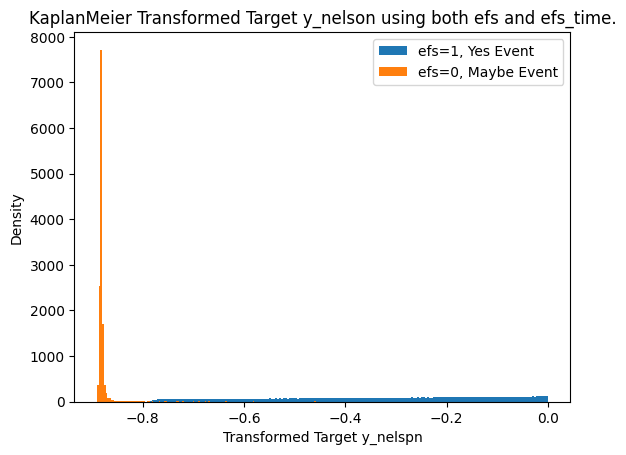

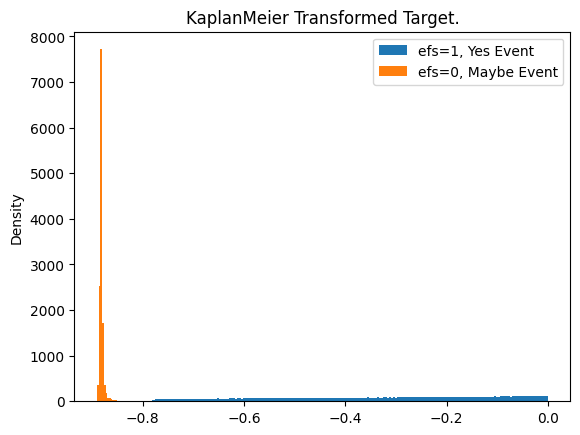

In [13]:
import os
import joblib
def model_train(model,train,target,FEATURES,n_splits=10,random_state=42,strat_lab="race_group"):
    model_name = type(model).__name__.lower()
    print(f"Model : {model_name} Label : {target}",end=" ")
    train=create_stratified_folds(train,strat_lab,n_splits,random_state)
    oof = np.zeros(len(train))
    pred = np.zeros(len(test))
    for i in range(n_splits):
        x_train = train.loc[train.fold!=i,FEATURES].copy()
        y_train = train.loc[train.fold!=i,target]
        x_valid = train.loc[train.fold==i,FEATURES].copy()
        y_valid = train.loc[train.fold==i,target]
        x_test = test[FEATURES].copy()
        model_path = f"/kaggle/input/boosting-models-cibmtr/saved_models/{model_name}_{target}_rs{random_state}_fold{i}_strat{strat_lab}"
        if (("xgb" in model_name) or ("lgbm" in model_name)):
            model=joblib.load(f"{model_path}.pkl")
        elif ("cat" in model_name):
            model=CatBoostRegressor().load_model(f"{model_path}.cbm")

        # INFER OOF
        oof[train.index[train.fold==i]] = (model.predict(x_valid))
        # INFER TEST
        pred+= (model.predict(x_test))
    y_true = train[["ID","efs","efs_time","race_group"]].copy()
    y_pred = train[["ID"]].copy()
    y_pred["prediction"] = oof

    m = score(y_true.copy(), y_pred.copy(), "ID")
    mape = mean_absolute_percentage_error(train[target],oof)  
    
    print(f"Overall CV = {m:.3f} and mape = {mape:.3f}")
    return oof,pred,m


models = {
    "y_nel": [
        XGBRegressor(reg_lambda=2,max_depth=4,colsample_bytree=0.55,  subsample=0.8,  n_estimators=5000,  learning_rate=0.02,  
                     enable_categorical=True,min_child_weight=80,early_stopping_rounds=200,n_jobs=4
        ),
        CatBoostRegressor(reg_lambda=2,learning_rate=0.09, subsample=0.95, grow_policy="Lossguide", early_stopping_rounds=100),
        LGBMRegressor(reg_lambda=2,max_depth=4, colsample_bytree=0.3, subsample=0.9, n_estimators=5000, learning_rate=0.02, 
                      objective="regression", verbose=-1, early_stopping_rounds=300, enable_categorical=True, 
                      min_child_weight=80, n_jobs=4)
        
    ],
    "y": [
        XGBRegressor(reg_lambda=2,max_depth=4, colsample_bytree=0.55, subsample=0.8, n_estimators=5000, learning_rate=0.02, 
                     enable_categorical=True, min_child_weight=80, early_stopping_rounds=300, n_jobs=4),
        CatBoostRegressor(reg_lambda=2,learning_rate=0.095, subsample=0.9, early_stopping_rounds=100),
        LGBMRegressor(reg_lambda=2,max_depth=5, colsample_bytree=0.35, subsample=0.9, n_estimators=3000, learning_rate=0.02, 
                      objective="regression", verbose=-1, early_stopping_rounds=100, n_jobs=4),
    ],
    "efs_time2": [
        XGBRegressor(reg_lambda=2,colsample_bytree=0.5, subsample=0.9, n_estimators=3000, learning_rate=0.02, enable_categorical=True, 
                     min_child_weight=70, objective="survival:cox", eval_metric="cox-nloglik", n_jobs=4),
        CatBoostRegressor(reg_lambda=2,loss_function="Cox", iterations=500, learning_rate=0.15, subsample=0.9, use_best_model=False),
    ],
}


train["y_nel"] = create_nelson(train)
train.loc[train.efs == 0, "y_nel"] = (-(-train.loc[train.efs == 0, "y_nel"])**0.5)
plt.hist(train.loc[train.efs==1,"y_nel"],bins=200,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y_nel"],bins=200,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y_nelspn")
plt.ylabel("Density")
plt.title("KaplanMeier Transformed Target y_nelson using both efs and efs_time.")
plt.legend()
plt.show()

train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train.efs == 0, "y"] = ((train.loc[train.efs == 0, "y"])**1.1)
plt.hist(train.loc[train.efs==1,"y_nel"],bins=200,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y_nel"],bins=200,label="efs=0, Maybe Event")
# plt.xlabel("Transformed Target kaplan")
plt.ylabel("Density")
plt.title("KaplanMeier Transformed Target.")
plt.legend()
plt.show()

train["efs_time2"] = train.efs_time.copy()
train.loc[:,"efs_time2"] **= 2
train.loc[train.efs==0,"efs_time2"] *= -1


In [14]:
train["y_nel"] = create_nelson(train)
train.loc[train.efs == 0, "y_nel"] = (-(-train.loc[train.efs == 0, "y_nel"])**0.5)
train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train.efs == 0, "y"] = ((train.loc[train.efs == 0, "y"])**1.1)
all_oofs=[]
all_preds=[]
all_scores=[]
for label in ["y_nel","y","efs_time2"]:
    for strat_label in ["race_group"]:
        oof = np.zeros(len(train))
        pred = np.zeros(len(test))
        model_score=0
        for rs in [0,1,2,3,41,42,2025]:
            print("RS:" ,rs)
            for model in models[label]:   
                oof1,pred1,x=model_train(model,train,label,FEATURES,n_splits=10,random_state=20*(strat_label=="efs_time")+rs,strat_lab=strat_label)
                oof+=oof1
                pred+=pred1
                model_score+=x
            

    print(oof)
    print(pred)
    all_oofs.append(oof)
    all_preds.append(pred)
    all_scores.append(model_score)


RS: 0
Model : xgbregressor Label : y_nel Overall CV = 0.679 and mape = 4.611
Model : catboostregressor Label : y_nel Overall CV = 0.676 and mape = 4.629
Model : lgbmregressor Label : y_nel Overall CV = 0.678 and mape = 4.619
RS: 1
Model : xgbregressor Label : y_nel Overall CV = 0.680 and mape = 4.457
Model : catboostregressor Label : y_nel Overall CV = 0.676 and mape = 4.525
Model : lgbmregressor Label : y_nel Overall CV = 0.678 and mape = 4.506
RS: 2
Model : xgbregressor Label : y_nel Overall CV = 0.680 and mape = 4.522
Model : catboostregressor Label : y_nel Overall CV = 0.677 and mape = 4.461
Model : lgbmregressor Label : y_nel Overall CV = 0.678 and mape = 4.500
RS: 3
Model : xgbregressor Label : y_nel Overall CV = 0.680 and mape = 4.522
Model : catboostregressor Label : y_nel Overall CV = 0.676 and mape = 4.508
Model : lgbmregressor Label : y_nel Overall CV = 0.679 and mape = 4.565
RS: 41
Model : xgbregressor Label : y_nel Overall CV = 0.680 and mape = 4.470
Model : catboostregres

In [15]:
pairwise_ranking_oofy_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] =sum(np.log1p(700+(all_oofs[i])*all_scores[i]) for i in range(len(all_oofs)))+pairwise_ranking_oof*1.2

m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)




Overall CV for Ensemble = 0.685276425409225


In [16]:
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")

sub["prediction"] = sum(np.log1p(700+(all_preds[i])*all_scores[i]/10) for i in range(len(all_preds)))+pairwise_ranking_pred*1.2

sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()


Sub shape: (3, 2)


,ID,prediction
0,28800,18.190499
1,28801,20.216788
2,28802,17.673048
